# Classification Models

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nbimporter

import TrainTestEvalSplit as split

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#Classification Metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from yellowbrick.classifier import ClassPredictionError

import pickle

from sklearn.model_selection import KFold
from sklearn.utils import check_X_y
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import SelectFromModel

Importing Jupyter notebook from TrainTestEvalSplit.ipynb


## Import File

In [2]:
full_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Full.csv")
full_df["Date"] = pd.to_datetime(full_df["Date"], format="%Y-%m-%d")

full_df.head()

,Date,Hour,Nieuwmarkt Lat,Nieuwmarkt Lon,Nieuwezijds Kolk Lat,Nieuwezijds Kolk Lon,Dam Lat,Dam Lon,Spui Lat,Spui Lon,...,Nieuwmarkt score,Nieuwmarkt weight,Nieuwezijds Kolk score,Nieuwezijds Kolk weight,Dam score,Dam weight,Spui score,Spui weight,Centraal Station score,Centraal Station weight
0,2018-03-11,100,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,0.000000,0.882141,0.000000,0.587521,-7.303229,-0.070905,-0.000000,-0.681885,163.979433,0.346680
1,2018-03-11,2100,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,352.242352,1.015108,83.818349,0.421198,-448.251607,-0.353790,-130.349894,-0.972760,1668.972876,0.432376
2,2018-03-11,2100,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,384.307874,1.107515,8.440208,0.042413,-1899.118956,-1.498910,-352.192566,-2.628303,3994.026557,1.034722
3,2018-03-11,2200,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,342.287656,1.049962,42.314730,0.253382,-1231.740804,-1.207589,-279.710090,-2.350505,3446.831547,1.043862
4,2018-03-11,2200,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,343.524310,1.053756,73.166332,0.438122,-730.059883,-0.715745,-196.552679,-1.651703,2770.301160,0.838977


## Train/Test/Eval

In [8]:
size = 0.8
kf = KFold(n_splits=10, shuffle=True, random_state=42)
stations = ["Nieuwmarkt", "Nieuwezijds Kolk", "Dam", "Spui", "Centraal Station"]

In [9]:
full_df = split.clasCrowdednessCounts(full_df)

In [10]:
x_train, y_train, x_eval, y_eval, train_dates = split.trainTestSplit(full_df, size, stations)

## Feature Selection

In [30]:
X=x_train.drop(columns={"Date"})
y=y_train["CrowdednessCount"]

feature_model = SelectFromModel(RandomForestClassifier(n_estimators=250, random_state=42))
feature_model.fit(X, y)

selected_feat= X.columns[(feature_model.get_support())]

print(selected_feat)

Index(['hour_sin', 'hour_cos', 'Nieuwmarkt score', 'Nieuwmarkt weight',
       'Nieuwezijds Kolk score', 'Dam score', 'Centraal Station score'],
      dtype='object')


## Models

### Baseline
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)

#### Training

In [11]:
base = DummyClassifier(strategy="stratified", random_state=42)

In [12]:
labels = [1, 2, 3, 4]

mean_acc = 0

mean_precision = 0
mean_recall = 0
mean_f1_score = 0

for train_index, test_index in kf.split(train_dates):

    x = x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"})
    y = y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"]
    
    base.fit(x, y)

    x_test = x_train[x_train["Date"].isin(train_dates[test_index])].drop(columns={"Date"})
    y_test = y_train[y_train["Date"].isin(train_dates[test_index])]["CrowdednessCount"]
    
    y_pred_base = base.predict(x_test)
    
    mean_acc += accuracy_score(y_test, y_pred_base)

    mean_precision += precision_score(y_test, y_pred_base, average=None)
    mean_recall += recall_score(y_test, y_pred_base, average=None)
    mean_f1_score += f1_score(y_test, y_pred_base, average=None)

mean_acc = round(((mean_acc / 10) * 100),2)
mean_precision = (mean_precision / 10) * 100
mean_recall = (mean_recall / 10) * 100
mean_f1_score = (mean_f1_score / 10) * 100

print("Mean Accuracy Score: ", mean_acc, "\n")

for i in range(len(labels)):
    print("For label {0}".format(labels[i]))
    print("Mean Precision Score: ", round(mean_precision[i], 2))
    print("Mean Recall Score: ", round(mean_recall[i], 2))
    print("Mean F1 Score: ", round(mean_f1_score[i], 2), "\n")

Mean Accuracy Score:  24.7 

For label 1
Mean Precision Score:  24.67
Mean Recall Score:  24.39
Mean F1 Score:  24.52 

For label 2
Mean Precision Score:  24.76
Mean Recall Score:  24.73
Mean F1 Score:  24.72 

For label 3
Mean Precision Score:  24.86
Mean Recall Score:  24.71
Mean F1 Score:  24.74 

For label 4
Mean Precision Score:  24.65
Mean Recall Score:  25.14
Mean F1 Score:  24.77 



#### Test

Accuracy Score:  0.24675498461126724
              precision    recall  f1-score   support

           1       0.26      0.24      0.25      3963
           2       0.25      0.25      0.25      3724
           3       0.24      0.25      0.25      3623
           4       0.23      0.24      0.24      3636

   micro avg       0.25      0.25      0.25     14946
   macro avg       0.25      0.25      0.25     14946
weighted avg       0.25      0.25      0.25     14946



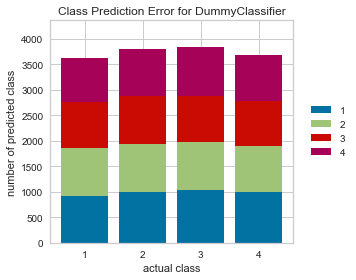

In [13]:
y_pred_eval_base = base.predict(x_eval)
print("Accuracy Score: ", accuracy_score(y_eval, y_pred_eval_base))
print(classification_report(y_eval, y_pred_eval_base))

visualizer = ClassPredictionError(
    base
)

visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])
visualizer.score(x_eval, y_eval)
g = visualizer.poof()

### Random Forrest Classifier 
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [15]:
rfc = RandomForestClassifier(n_estimators=375, criterion='gini', max_features='auto', bootstrap=True,
                            class_weight="balanced")

#### Training

In [16]:
labels = [1, 2, 3, 4]

mean_acc = 0

mean_precision = 0
mean_recall = 0
mean_f1_score = 0

for train_index, test_index in kf.split(train_dates):
    
    x = x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"})
    y = y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"]
    
    rfc.fit(x, y)
    
    x_test = x_train[x_train["Date"].isin(train_dates[test_index])].drop(columns={"Date"})
    y_test = y_train[y_train["Date"].isin(train_dates[test_index])]["CrowdednessCount"]
    
    y_pred_base = rfc.predict(x_test)
    
    mean_acc += accuracy_score(y_test, y_pred_base)

    mean_precision += precision_score(y_test, y_pred_base, average=None)
    mean_recall += recall_score(y_test, y_pred_base, average=None)
    mean_f1_score += f1_score(y_test, y_pred_base, average=None)

mean_acc = round(((mean_acc / 10) * 100),2)
mean_precision = (mean_precision / 10) * 100
mean_recall = (mean_recall / 10) * 100
mean_f1_score = (mean_f1_score / 10) * 100

print("Mean Accuracy Score: ", mean_acc, "\n")

for i in range(len(labels)):
    print("For label {0}".format(labels[i]))
    print("Mean Precision Score: ", round(mean_precision[i], 2))
    print("Mean Recall Score: ", round(mean_recall[i], 2))
    print("Mean F1 Score: ", round(mean_f1_score[i], 2), "\n")

Mean Accuracy Score:  85.31 

For label 1
Mean Precision Score:  92.48
Mean Recall Score:  86.59
Mean F1 Score:  89.43 

For label 2
Mean Precision Score:  85.41
Mean Recall Score:  85.07
Mean F1 Score:  85.23 

For label 3
Mean Precision Score:  79.41
Mean Recall Score:  80.69
Mean F1 Score:  80.03 

For label 4
Mean Precision Score:  84.66
Mean Recall Score:  88.86
Mean F1 Score:  86.68 



#### Hyperparameter Tuning

In [14]:
rfc = RandomForestClassifier()

n_estimators = [325, 350, 375]
criterion = ["gini", "entropy"]
max_features = ["log2", "auto", None]
bootstrap = [True]
oob_score = [True, False]
class_weight = ["balanced", "balanced_subsample", None]

params = {"n_estimators": n_estimators,
         "criterion": criterion,
         "max_features": max_features,
         "bootstrap": bootstrap,
          "oob_score": oob_score,
         "class_weight": class_weight}

scores = ["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"]

hyp = RandomizedSearchCV(estimator=rfc, param_distributions=params, n_iter=10, scoring=scores, n_jobs=4, cv=10,
                        random_state=42, refit="f1_weighted")

rfc_model = hyp.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])

In [15]:
print("Best estimator: ", rfc_model.best_estimator_)
print("Best F1 score: ", rfc_model.best_score_)

Best estimator:  RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=350, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Best F1 score:  0.768739470722851


#### Test

Accuracy Score:  0.8637762612070119
              precision    recall  f1-score   support

           1       0.94      0.87      0.90      3963
           2       0.87      0.85      0.86      3724
           3       0.80      0.82      0.81      3623
           4       0.85      0.91      0.88      3636

   micro avg       0.86      0.86      0.86     14946
   macro avg       0.86      0.86      0.86     14946
weighted avg       0.87      0.86      0.86     14946



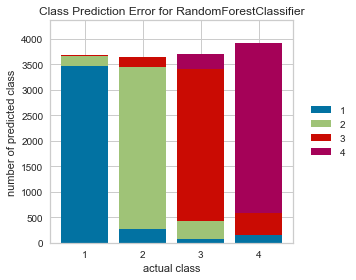

In [17]:
y_pred_eval_rfc = rfc.predict(x_eval)

print("Accuracy Score: ", accuracy_score(y_eval, y_pred_eval_rfc))
print(classification_report(y_eval, y_pred_eval_rfc))

visualizer = ClassPredictionError(
    rfc
)

visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])
visualizer.score(x_eval, y_eval)
g = visualizer.poof()

#### Save Model to File

In [21]:
filename = "../../../Data_thesis/Models/rfc_model.sav"

pickle.dump(rfc, open(filename, 'wb'))

### XGBoost 
Implement [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

#### Training

In [18]:
xgbc = xgb.XGBClassifier(learning_rate=0.05, n_estimators=200, booster='gbtree', objective='multi:softprob',
                        random_state=42, n_jobs=4)

In [19]:
labels = [1, 2, 3, 4]

mean_acc = 0

mean_precision = 0
mean_recall = 0
mean_f1_score = 0

for train_index, test_index in kf.split(train_dates):
    
    x = x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"})
    y = y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"]
    
    xgbc.fit(x, y)
    
    x_test = x_train[x_train["Date"].isin(train_dates[test_index])].drop(columns={"Date"})
    y_test = y_train[y_train["Date"].isin(train_dates[test_index])]["CrowdednessCount"]
    
    y_pred_base = xgbc.predict(x_test)
    
    mean_acc += accuracy_score(y_test, y_pred_base)

    mean_precision += precision_score(y_test, y_pred_base, average=None)
    mean_recall += recall_score(y_test, y_pred_base, average=None)
    mean_f1_score += f1_score(y_test, y_pred_base, average=None)

mean_acc = round(((mean_acc / 10) * 100),2)
mean_precision = (mean_precision / 10) * 100
mean_recall = (mean_recall / 10) * 100
mean_f1_score = (mean_f1_score / 10) * 100

print("Mean Accuracy Score: ", mean_acc, "\n")

for i in range(len(labels)):
    print("For label {0}".format(labels[i]))
    print("Mean Precision Score: ", round(mean_precision[i], 2))
    print("Mean Recall Score: ", round(mean_recall[i], 2))
    print("Mean F1 Score: ", round(mean_f1_score[i], 2), "\n")

Mean Accuracy Score:  79.97 

For label 1
Mean Precision Score:  88.6
Mean Recall Score:  83.13
Mean F1 Score:  85.76 

For label 2
Mean Precision Score:  79.09
Mean Recall Score:  79.64
Mean F1 Score:  79.35 

For label 3
Mean Precision Score:  72.95
Mean Recall Score:  70.81
Mean F1 Score:  71.84 

For label 4
Mean Precision Score:  79.7
Mean Recall Score:  86.3
Mean F1 Score:  82.83 



#### Hyperparameter Tuning

In [16]:
xgbc = xgb.XGBClassifier()

learning_rate = [0.05, 0.1, 0.25, 0.5]
n_estimators = [175, 225, 200]
booster = ["gbtree"]
objective = ["multi:softmax", "multi:softprob"]

params = {"learning_rate": learning_rate,
         "n_estimators": n_estimators,
         "booster": booster,
         "objective": objective}

scores = ["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"]

hyp = RandomizedSearchCV(estimator=xgbc, param_distributions=params, n_iter=10, scoring=scores, n_jobs=4, cv=10,
                        random_state=42, refit="f1_weighted")

xgbc_model = hyp.fit(x_train.drop(columns={"Date"}).values, y_train["CrowdednessCount"].values)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [17]:
print("Best estimator: ", xgbc_model.best_estimator_)
print("Best F1 score: ", xgbc_model.best_score_)

Best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=175,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Best F1 score:  0.706366969259074


#### Test

Accuracy Score:  0.8074401177572594
              precision    recall  f1-score   support

           1       0.89      0.84      0.87      3963
           2       0.80      0.78      0.79      3724
           3       0.73      0.72      0.72      3623
           4       0.81      0.88      0.84      3636

   micro avg       0.81      0.81      0.81     14946
   macro avg       0.81      0.81      0.81     14946
weighted avg       0.81      0.81      0.81     14946



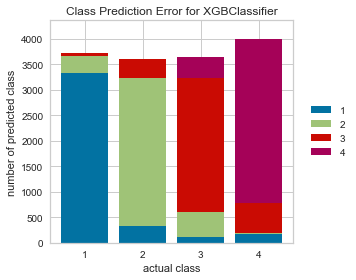

In [20]:
y_pred_eval_xgbc = xgbc.predict(x_eval)

print("Accuracy Score: ", accuracy_score(y_eval, y_pred_eval_xgbc))
print(classification_report(y_eval, y_pred_eval_xgbc))

visualizer = ClassPredictionError(
    xgbc
)

visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])
visualizer.score(x_eval, y_eval)
g = visualizer.poof()

#### Save Model to File

In [22]:
filename = "../../../Data_thesis/Models/xgbc_model.sav"

pickle.dump(xgbc, open(filename, 'wb'))